In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:
torch.cuda.empty_cache() # empty cache

In [ ]:
torch.cuda.is_available() # check gpu availability

True

In [ ]:
# connecting google drive to colab
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# reading train and test data
%cd /content/drive/My Drive/Deakin_units/T1-2025/SIT764/sentiment-analysis/

/content/drive/My Drive/Deakin_units/T1-2025/SIT764/sentiment-analysis


In [ ]:
#load model
model_name = 'google/flan-t5-large'
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name, device_map="auto")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
# predict sentiment
def predict_sentiment(text):
    #input_text = f"Classify Sentiment: {text}"
    input_text = f"Classify the sentiment of the following text as Positive, Negative, or Neutral: {text}. Output only one of these labels."

    inputs = tokenizer(input_text, return_tensors="pt", padding=True, truncation=True, max_length=512)

    inputs = {key: value.to(device) for key, value in inputs.items()}

    with torch.no_grad():
        outputs = model.generate(**inputs)

    sentiment = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return sentiment

In [ ]:
# load test data and create sample
test_data = pd.read_csv('data/new_test.csv')
test_sample = test_data.sample(n=100, random_state=42)

In [ ]:
test_sample.shape

(100, 11)

In [ ]:
test_sample['sentiment'].value_counts()

,count
sentiment,
positive,47
neutral,34
negative,19


In [ ]:
# apply sentiment prediction
test_sample["predicted_sentiment"] = test_sample["commentsReview"].apply(predict_sentiment)

In [ ]:
test_sample.head()

,Unnamed: 0,Column1,urlDrugName,rating,effectiveness,sideEffects,condition,benefitsReview,sideEffectsReview,commentsReview,sentiment,predicted_sentiment
294,295,3460,ambien-cr,10,Highly Effective,Mild Side Effects,insomnia,much improved sleep without waking in the midd...,none really. Maybe groggy but not terribly.,Took 1 pill at bedtime,positive,Neutral
453,454,410,imitrex,10,Highly Effective,No Side Effects,migraine headaches,Complete relief from pain with one 100 mg tabl...,"A little ""fuzzy headed"" until it took effect.",This is taken as needed. It works best to take...,positive,Positive
638,639,535,trazodone,9,Highly Effective,Mild Side Effects,insomnia,Helps me to sleep although does NOT help RLS. ...,"At first I was terrible groggy, but I adjusted.",I take it every night about 1/2 hour before I ...,positive,Positive
139,140,3346,lipitor,7,Considerably Effective,No Side Effects,high cholesterol,lower cholesterol,none,daily with water at nite. and every three mont...,neutral,Positive
539,540,2383,synthroid,10,Highly Effective,No Side Effects,hashimotos syndrome - hypothyroid symptoms,Synthroid replaces the thyroid hormones not ma...,Provided annual blood tests are administered t...,Treatment includes annual blood test to monito...,positive,Positive


In [ ]:
test_sample['predicted_sentiment'] = test_sample['predicted_sentiment'].str.lower()
test_sample.head(5)

,Unnamed: 0,Column1,urlDrugName,rating,effectiveness,sideEffects,condition,benefitsReview,sideEffectsReview,commentsReview,sentiment,predicted_sentiment
294,295,3460,ambien-cr,10,Highly Effective,Mild Side Effects,insomnia,much improved sleep without waking in the midd...,none really. Maybe groggy but not terribly.,Took 1 pill at bedtime,positive,neutral
453,454,410,imitrex,10,Highly Effective,No Side Effects,migraine headaches,Complete relief from pain with one 100 mg tabl...,"A little ""fuzzy headed"" until it took effect.",This is taken as needed. It works best to take...,positive,positive
638,639,535,trazodone,9,Highly Effective,Mild Side Effects,insomnia,Helps me to sleep although does NOT help RLS. ...,"At first I was terrible groggy, but I adjusted.",I take it every night about 1/2 hour before I ...,positive,positive
139,140,3346,lipitor,7,Considerably Effective,No Side Effects,high cholesterol,lower cholesterol,none,daily with water at nite. and every three mont...,neutral,positive
539,540,2383,synthroid,10,Highly Effective,No Side Effects,hashimotos syndrome - hypothyroid symptoms,Synthroid replaces the thyroid hormones not ma...,Provided annual blood tests are administered t...,Treatment includes annual blood test to monito...,positive,positive


In [ ]:
(test_sample['predicted_sentiment'].iloc[0])

'neutral'

In [ ]:
test_sample['predicted_sentiment'].value_counts()

,count
predicted_sentiment,
positive,54
negative,29
neutral,17


In [ ]:
# evaluate performance
accuracy = accuracy_score(test_sample["sentiment"], test_sample["predicted_sentiment"])
print(f"Accuracy on sample: {accuracy:.4f}")

Accuracy on sample: 0.5500


In [ ]:
report = classification_report(test_sample["sentiment"], test_sample["predicted_sentiment"], output_dict=True)
print(classification_report(test_sample["sentiment"], test_sample["predicted_sentiment"]))

              precision    recall  f1-score   support

    negative       0.41      0.63      0.50        19
     neutral       0.47      0.24      0.31        34
    positive       0.65      0.74      0.69        47

    accuracy                           0.55       100
   macro avg       0.51      0.54      0.50       100
weighted avg       0.54      0.55      0.53       100



In [ ]:
test_sample.to_csv('predicted.csv')

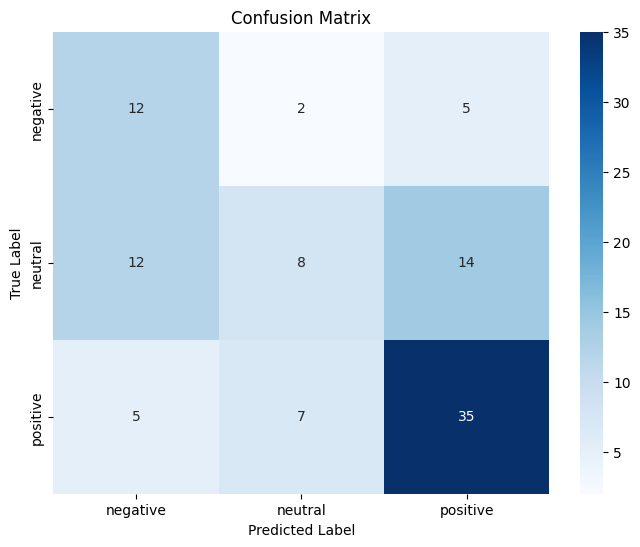

In [ ]:
labels = sorted(test_sample["sentiment"].unique())  # Ensure correct order
conf_matrix = confusion_matrix(test_sample["sentiment"], test_sample["predicted_sentiment"], labels=labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
# plt.savefig("confusion_matrix.png")
plt.show()